## What to do?

Just run the cells that you need.
There's different sections for the different model architectures

In [1]:
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import backend as K
from time import time
from models import ResNet, ResNetLstm, DeepSpeech2Attention, DeepSpeech2
from collections import Counter
import matplotlib.pyplot as plt
import tensorflow as tf
import os
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix   


import training and validation data
not included in repo, set your own folder location

In [2]:
X_train = np.load('./data/X_train.npy')
Y_train = np.load('./data/Y_train.npy')
X_val = np.load('./data/X_val.npy')
Y_val = np.load('./data/Y_val.npy')

In [3]:
x = np.concatenate((Y_train, Y_val), axis=0)
unique, counts = np.unique(x, return_counts=True)

print(np.asarray((unique, counts)).T)

[[    0  2377]
 [    1  2375]
 [    2  2375]
 [    3  2359]
 [    4  2353]
 [    5  2367]
 [    6  2367]
 [    7  2357]
 [    8  2380]
 [    9  2372]
 [   10   402]
 [   11 41039]]


In [4]:
classes = ['yes', 'no', 
           'up', 'down', 
           'left', 'right', 
           'on', 'off', 
           'stop', 'go', 
           'silence', 'unknown']

all_classes = [x for x in classes[:11]]
for ind, cl in enumerate(os.listdir('data/train/audio/')):
    if cl not in classes:
        all_classes.append(cl)
print(all_classes)

['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'bed', 'bird', 'cat', 'dog', 'eight', 'five', 'four', 'happy', 'house', 'marvin', 'nine', 'one', 'seven', 'sheila', 'six', 'three', 'tree', 'two', 'wow', 'zero']


The training data is very unbalanced with a much larger 'unknown' class.
keras has a class_weight paramter in the fit() function that will give higher penalties to missclassifications in underrepresented classes. It takes a dict like this:

In [5]:
def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: float(majority/count) for cls, count in counter.items()}  

class_weights = get_class_weights(Y_train)


In [6]:
class_weights

{11: 1.0,
 3: 17.574224343675418,
 9: 17.432765151515152,
 4: 17.482431149097817,
 1: 17.490736342042755,
 7: 17.52403617325083,
 6: 17.449289099526066,
 5: 17.441023211747986,
 10: 101.98891966759003,
 8: 17.253045923149017,
 2: 17.4080378250591,
 0: 17.399810964083176}

some constants we need for all models

In [7]:
input_size = X_train.shape[1:]
batch_size = 256
input_size

(122, 85, 1)

## First the ResNet
declare filters for each block of blocks and set output size.

In [8]:
filters_list = [8,16,32]
output_size = 12

In [9]:
#adjust these strings for organizeing the saved files
date = '1506'
arch = 'deep_speech22'

Build the model

In [10]:
# sr = ResNet(filters_list, input_size, output_size)
# sr = ResNetLstm(filters_list, input_size, output_size)
sr = DeepSpeech2(filters_list, input_size, output_size)

sr.build()
sr.m.compile(loss='categorical_crossentropy', 
             optimizer='Adam', 
             metrics=['accuracy'])
sr.m.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 122, 85, 1)]      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 122, 85, 1)        340       
_________________________________________________________________
conv_1 (Conv2D)              (None, 61, 43, 32)        14432     
_________________________________________________________________
conv_1_bn (BatchNormalizatio (None, 61, 43, 32)        128       
_________________________________________________________________
conv_1_relu (ReLU)           (None, 61, 43, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 61, 22, 32)        236544    
_________________________________________________________________
conv_2_bn (BatchNormalizatio (None, 61, 22, 32)        128   

In [11]:
# to save a png of the model you need pydot and graphviz installed
plot_model(sr.m, 
           to_file = './models/{}_{}.png'.format(arch,date), 
           show_shapes = True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [12]:
#callbacks, remember to make folders to store files 
checkpointer = ModelCheckpoint(filepath='./models/{}_{}_best.h5'.format(arch, date),
                               verbose=0,
                               monitor='val_accuracy',
                               mode="auto",
                               save_best_only=True)
   
earlystopping = EarlyStopping()

tensorboard = TensorBoard(log_dir = './logs/{}_{}'.format(date, time()), 
                          histogram_freq = 0, 
                          write_graph = True, 
                          write_images = True)

train the model
the history object stores training data for later access, like plotting training curves

In [13]:
X_train.shape

(58284, 122, 85, 1)

In [14]:
sr.m = tf.keras.models.load_model(r'C:\Users\Michal\Desktop\semestr2\MGU\speech-master\models\deep_speech2_1506_best.h5')

In [15]:
history = sr.m.fit(X_train, 
                   to_categorical(Y_train), 
                   batch_size = batch_size, 
                   epochs = 25, 
                   verbose = 1, shuffle = True, 
                   class_weight = class_weights,
                   validation_data = (X_val, to_categorical(Y_val)), 
                   callbacks = [checkpointer]) # add more callbacks if you want

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 58284 samples, validate on 6839 samples
Epoch 1/25
58284/58284 [==============================] - 189s 3ms/sample - loss: 0.4116 - accuracy: 0.9733 - val_loss: 1.7385 - val_accuracy: 0.9469
Epoch 2/25
58284/58284 [==============================] - 188s 3ms/sample - loss: 0.4362 - accuracy: 0.9712 - val_loss: 2.2422 - val_accuracy: 0.9478
Epoch 3/25
58284/58284 [==============================] - 190s 3ms/sample - loss: 0.5334 - accuracy: 0.9689 - val_loss: 2.5980 - val_accuracy: 0.9500
Epoch 4/25
58284/58284 [==============================] - 192s 3ms/sample - loss: 0.4357 - accuracy: 0.9731 - val_loss: 2.4107 - val_accuracy: 0.9500
Epoch 5/25
58284/58284 [==============================] - 191s 3ms/sample - loss: 0.4156 - accuracy: 0.9720 - val_loss: 2.3972 - val_accuracy: 0.9507
Epoch 6/25
58284/58284 [==============================] - 191s 3ms/sample - loss: 0.5381 - accuracy: 0.9707 - val_loss: 2.2521 - val_accuracy: 0.9335
E

KeyboardInterrupt: 

In [16]:
sr.m.save("./models/ds2_nice_model.h5")

In [ ]:
sr.m.save_weights("./models/{}_{}_last.h5".format(arch, date)) 


plot the training graphs, and save them

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


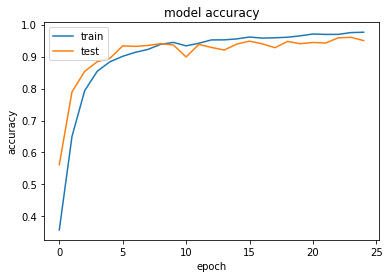

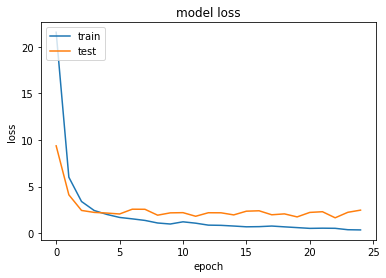

In [22]:
#%% visualize training
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('graphs/{}_{}_acc.png'.format(arch, date),bbox_inches='tight')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('graphs/{}_{}_loss.png'.format(arch, date), bbox_inches='tight')
plt.show()

predict the validation classification and score

In [ ]:
val_pred = sr.m.predict(X_val, batch_size = batch_size, verbose = 1)

In [ ]:
print(classification_report(Y_val, np.argmax(val_pred, axis = 1), target_names = classes, digits = 3))

In [ ]:
print(confusion_matrix(Y_val, np.argmax(val_pred, axis = 1)))

### Ensemble

In [38]:
def load_all_models():
    all_models = []
    models_list = [os.path.join("./models/", elem) for elem in os.listdir("./models/")]
    for mod in models_list:
        # load model from file
        model = tf.keras.models.load_model(mod)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % model)
    return all_models

def define_stacked_model(members):
    # update all layers in all models to not be trainable
    for i in range(len(members)):
        model = members[i]
        for j, layer in enumerate(model.layers):
            # make not trainable
            if j <= len(model.layers)-3:
                layer.trainable = False
            # rename to avoid 'unique layer name' issue
            layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
    # define multi-headed input
    ensemble_visible = [model.input for model in members]
    # concatenate merge output from each model
    ensemble_outputs = [model.output for model in members]
    merge = tf.keras.layers.concatenate(ensemble_outputs)
    hidden = tf.keras.layers.Dense(100, activation='relu')(merge)
    output = tf.keras.layers.Dense(12, activation='softmax')(hidden)
    model = tf.keras.models.Model(inputs=ensemble_visible, outputs=output)
    # compile
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    return model

In [24]:
# load all models
members = load_all_models()
print('Loaded %d models' % len(members))

>loaded <tensorflow.python.keras.engine.training.Model object at 0x000001ED406FD648>
>loaded <tensorflow.python.keras.engine.training.Model object at 0x000001ED3F7D1348>
>loaded <tensorflow.python.keras.engine.training.Model object at 0x000001ED44979088>
>loaded <tensorflow.python.keras.engine.training.Model object at 0x000001ED481023C8>
>loaded <tensorflow.python.keras.engine.training.Model object at 0x000001ED4CCBE288>
>loaded <tensorflow.python.keras.engine.training.Model object at 0x000001ED718BAC88>
>loaded <tensorflow.python.keras.engine.training.Model object at 0x000001ED79B2F988>
>loaded <tensorflow.python.keras.engine.training.Model object at 0x000001ED804E6BC8>
>loaded <tensorflow.python.keras.engine.training.Model object at 0x000001ED79B3BD48>
Loaded 9 models


In [39]:
model = define_stacked_model(members) 
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ensemble_7_ensemble_7_ensemble_ [(None, 122, 85, 1)] 0                                            
__________________________________________________________________________________________________
ensemble_7_ensemble_7_ensemble_ (None, 122, 85, 8)   80          ensemble_7_ensemble_7_ensemble_7_
__________________________________________________________________________________________________
ensemble_6_ensemble_6_ensemble_ [(None, 122, 85, 1)] 0                                            
__________________________________________________________________________________________________
ensemble_7_ensemble_7_ensemble_ (None, 61, 43, 8)    0           ensemble_7_ensemble_7_ensemble_7_
____________________________________________________________________________________________

In [40]:
#callbacks, remember to make folders to store files 
checkpointer = ModelCheckpoint(filepath='./models/ensemble_best_ft.h5'.format(arch, date),
                               verbose=0,
                               monitor='val_accuracy',
                               mode="auto",
                               save_best_only=True)
   
earlystopping = EarlyStopping()

tensorboard = TensorBoard(log_dir = './logs/{}_{}'.format(date, time()), 
                          histogram_freq = 0, 
                          write_graph = True, 
                          write_images = True)

train the model
the history object stores training data for later access, like plotting training curves

In [41]:
X_train.shape

(58284, 122, 85, 1)

In [42]:
history = sr.m.fit([X_train for _ in range(len(members))], 
                   to_categorical(Y_train), 
                   batch_size = batch_size, 
                   epochs = 25, 
                   verbose = 1, shuffle = True, 
                   class_weight = class_weights,
                   validation_data = ([X_val for _ in range(len(members))], to_categorical(Y_val)), 
                   callbacks = [checkpointer]) # add more callbacks if you want

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 58284 samples, validate on 6839 samples
Epoch 1/25
58284/58284 [==============================] - 182s 3ms/sample - loss: 0.2399 - accuracy: 0.9813 - val_loss: 1.9109 - val_accuracy: 0.9569
Epoch 2/25
58284/58284 [==============================] - 188s 3ms/sample - loss: 0.2180 - accuracy: 0.9837 - val_loss: 2.2487 - val_accuracy: 0.9564
Epoch 3/25
58284/58284 [==============================] - 191s 3ms/sample - loss: 0.2718 - accuracy: 0.9811 - val_loss: 2.0811 - val_accuracy: 0.9561
Epoch 4/25
58284/58284 [==============================] - 189s 3ms/sample - loss: 0.2553 - accuracy: 0.9825 - val_loss: 2.5914 - val_accuracy: 0.9613
Epoch 5/25
58284/58284 [==============================] - 189s 3ms/sample - loss: 0.3501 - accuracy: 0.9793 - val_loss: 2.1616 - val_accuracy: 0.9560
Epoch 6/25
58284/58284 [==============================] - 190s 3ms/sample - loss: 0.3200 - accuracy: 0.9807 - val_loss: 2.7155 - val_accuracy: 0.9558
E

KeyboardInterrupt: 

## Now the CTC model

In [7]:
from models import CTC, ctc_lambda_func #used in the CTC build method
from ctc_utils import char_map, index_map, text_to_int, get_intseq, get_ctc_params

In [8]:
# dummy loss
def ctc(y_true, y_pred):
    return y_pred

The Conv1D layer at the top of the CTC model takes a 3-dimensional input, not 4 as the ResNet

In [9]:
sr_ctc = CTC((122,85), 28)
sr_ctc.build()

(<tensorflow.python.keras.engine.training.Model at 0x165277829c8>,
 <tensorflow.python.keras.engine.training.Model at 0x165276cfa48>)

In [10]:
sr_ctc.m.compile(loss = ctc, optimizer = 'adam', metrics = ['accuracy'])
sr_ctc.tm.compile(loss = ctc, optimizer = 'adam')

In [11]:
Y_train_all = np.load('data/Y_train_all.npy')
Y_val_all = np.load('data/Y_val_all.npy')

get the ctc parameters needed for the three extra ctc model inputs

In [12]:
labels, input_length, label_length = get_ctc_params(Y = Y_train_all, classes_list = all_classes)
labels_val, input_length_val, label_length_val = get_ctc_params(Y = Y_val_all, classes_list = all_classes)

In [15]:
checkpointer = ModelCheckpoint(filepath="./models/ctc_{}_best.h5".format(date),
                               verbose=0,
                               save_best_only=True)

In [17]:
history = sr_ctc.m.fit([np.squeeze(X_train), 
                            labels, 
                            input_length, 
                            label_length], 
                       np.zeros([len(Y_train_all)]), 
                       batch_size = 256, 
                       epochs = 10, 
                       validation_data = ([np.squeeze(X_val), 
                                           labels_val, 
                                           input_length_val, 
                                           label_length_val],
                                          np.zeros([len(Y_val_all)])), 
                       callbacks = [checkpointer], 
                       verbose = 1, shuffle = True)


Train on 58284 samples, validate on 6839 samples
Epoch 1/10
32000/58284 [===============>..............] - ETA: 6:12 - loss: 10.9938 - accuracy: 0.0021WARNING:tensorflow:Can save best model only with val_loss available, skipping.


KeyboardInterrupt: 

In [14]:
sr_ctc.m.save_weights('./models/ctc_{}.h5'.format(date))
sr_ctc.tm.load_weights('./models/ctc_{}_best.h5'.format(date))

dict_keys(['loss', 'val_acc', 'val_loss', 'acc'])


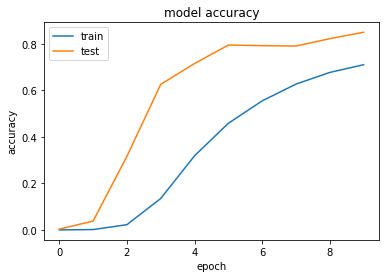

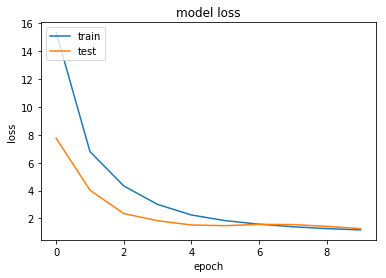

In [15]:
# plot
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('graphs/ctc_{}_acc.png'.format(date),bbox_inches='tight')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('graphs/ctc_{}_loss.png'.format(date), bbox_inches='tight')
plt.show()

decode the output of the predictions into strings

In [33]:
def str_out(dataset = X_val):
    k_ctc_out = K.ctc_decode(sr_ctc.tm.predict(np.squeeze(dataset), 
                                                verbose = 1), 
                             np.array([28 for _ in dataset]))
    decoded_out = K.eval(k_ctc_out[0][0])
    str_decoded_out = []
    for i, _ in enumerate(decoded_out):     
        str_decoded_out.append("".join([index_map[c] for c in decoded_out[i] if not c == -1]))
        
    return str_decoded_out

In [22]:
y_pred_val = str_out()

6839/6839 [==============================] - 4s 606us/step


Turn the target array Y_val_all into strings with 'all_classes[Y_val_all[i]]'

In [44]:
print('PREDICTED: \t REAL:')
for i in range(10):
    print(y_pred_val[i], '\t\t',all_classes[Y_val_all[i]])

PREDICTED: 	 REAL:
three 		 three
cat 		 cat
marvin 		 marvin
up 		 up
riget 		 right
off 		 off
left 		 left
four 		 four
tree 		 tree
seven 		 seven


In [47]:
print(classification_report([all_classes[Y_val_all[i]] for i, _ in enumerate(Y_val_all)], 
                            y_pred_val, labels = all_classes))

             precision    recall  f1-score   support

        yes       1.00      0.94      0.97       261
         no       0.96      0.82      0.88       270
         up       0.94      0.88      0.91       260
       down       0.98      0.81      0.89       264
       left       0.99      0.91      0.95       247
      right       0.98      0.88      0.93       256
         on       0.91      0.89      0.90       257
        off       0.96      0.28      0.43       256
       stop       0.99      0.89      0.94       246
         go       0.80      0.85      0.82       260
    silence       0.00      0.00      0.00        41
      house       1.00      0.95      0.97       173
       nine       0.98      0.87      0.92       230
       four       0.99      0.91      0.95       280
      happy       0.99      0.98      0.99       189
        wow       0.99      0.90      0.95       166
       five       0.97      0.82      0.89       242
       zero       1.00      0.93      0.96   

/home/chris/.conda/envs/deep/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


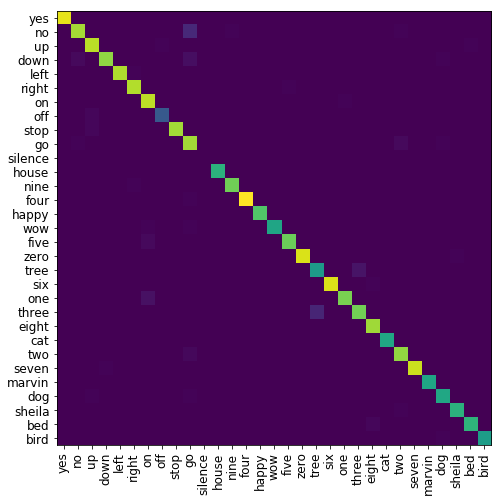

In [55]:
plt.figure(figsize = (8,8))
plt.imshow(confusion_matrix([all_classes[Y_val_all[i]] for i, _ in enumerate(Y_val_all)], 
                            y_pred_val, labels = all_classes))
plt.xticks(np.arange(0, len(all_classes)), all_classes, rotation = 'vertical', size = 12)
plt.yticks(np.arange(0, len(all_classes)), all_classes, size = 12)
plt.show()